# Winter 2022-2023 Wind Events at Kettle Ponds

Author: Daniel Hogan
Created: January 10, 2024

This notebook will start to address three main questions (with sub-focuses discussed below):
1) What events had the highest percentile of wind speeds?
2) What were the general storm characteristics? Were they related?
2) How much sublimation over the season came from these events?

### Imports


In [3]:
# general
import os
import glob
import datetime as dt
import json
# data 
import xarray as xr 
from sublimpy import utils, variables, tidy, turbulence
import numpy as np
import pandas as pd
from act import discovery, plotting
# plotting
import matplotlib.pyplot as plt
from metpy.cbook import get_test_data
from metpy.plots import add_metpy_logo, SkewT
import plotly.express as px 
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
# helper tools
from scripts.get_sail_data import get_sail_data
from scripts.helper_funcs import create_windrose_df, mean_sounding, simple_sounding
import scripts.helper_funcs as hf
from metpy import calc, units
# make plotly work 
init_notebook_mode(connected=True)
cf.go_offline()

nctoolkit is using Climate Data Operators version 2.3.0


## 1. What events at Kettle Ponds had the highest percentile of wind speeds?
We will begin to address this by looking at daily average wind speeds  from the SOS data to classify the top 95th percentile of windy days during the main snow season which we will call November 29, 2022 to May 7, 2023. This may need to be broken down further to capture wind events, but we'll start with this. We'll begin by comparing the days for 3-20 m wind speeds and compare tower-to-tower to make sure we have consistency at our location.

1) We'll first make some box plots of daily average wind speeds at each height and each tower to look at the total distribution over winter
2) We'll make a timeseries plot for each height bin and mark out the highest percentile of wind speeds for the year
3) We'll also make a correlation plot with tower on one axis and measurement height on the other.
4) We'll then filter to the days with the highest 5% of wind speeds over our period

In [2]:
start_date = '20221129'
end_date = '20230507'

In [4]:
%%capture
# Let's begin by downloading the SOS data and storing it in the /storage/ directory
output_dir = '/storage/dlhogan/synoptic_sublimation/sos_data/'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
sos_5min_ds = utils.download_sos_data(
                        start_date=start_date,
                        end_date=end_date,
                        variable_names=variables.DEFAULT_VARIABLES+hf.WATER_VAPOR_VARIABLES+hf.COUNT_VARIABLES,
                        local_download_dir=output_dir,
                        cache=True
                    );  

**NOTE**: Minimal filtering is done here. Will update with filters in the future.

In [5]:
# only get the wind variables and convert to dataframe
sos_5min_wind_df = sos_5min_ds[hf.WIND_VARIABLES].to_dataframe()
# resample to daily, get the mean for spd_*, u_*, v_* and w_* and the median for dir_*
# make a dictionary of the aggregations by iterating through the wind variables
sos_daily_avg_dict = {}
for var in hf.WIND_VARIABLES:
    if 'dir' in var:
        sos_daily_avg_dict[var] = 'median'
    else:
        sos_daily_avg_dict[var] = 'mean'
sos_daily_avg_df = sos_5min_wind_df.resample('1D').agg(sos_daily_avg_dict)
# reset index for sos_daily_avg_df
sos_daily_avg_df = sos_daily_avg_df.reset_index()

# resample to daily, get the max for spd_*, u_*, v_* and w_*
# make a dictionary of the aggregations by iterating through the wind variables
sos_daily_max_dict = {}
for var in hf.WIND_VARIABLES:
    if 'dir_' in var:
        continue
    else:
        sos_daily_max_dict[var] = 'max'
sos_daily_max_df = sos_5min_wind_df.resample('1D').agg(sos_daily_max_dict)

# find the wind direction during the max wind speed and add it to the daily max dataframe
idx = sos_5min_wind_df.filter(regex='spd_*').dropna().groupby(sos_5min_wind_df.filter(regex='spd_*').dropna().index.date).idxmax(skipna=True)
for dir_var in sos_5min_wind_df.filter(regex='dir_*').columns:
    # for the column, extract everything after the first underscore
    loc = dir_var.split('_', 1)[1]
    spd_loc = 'spd_' + loc
    # create a column with the max wind direction
    dates = sos_5min_wind_df.loc[idx[spd_loc].values, dir_var].index.date
    # fill a new dir_var colummn with nan
    sos_daily_max_df[dir_var] = np.nan
    sos_daily_max_df.loc[dates, dir_var] = sos_5min_wind_df.loc[idx[spd_loc].values, dir_var].values
# reset index for sos_daily_max_df
sos_daily_max_df = sos_daily_max_df.reset_index()

In [6]:
# print the average mean daily wind speed for spd_10m_uw
print('Average mean daily wind speed for spd_10m_uw: ', sos_daily_avg_df['spd_10m_uw'].mean())
# print the standard deviation of the mean daily wind speed for spd_10m_uw
print('Standard deviation of the mean daily wind speed for spd_10m_uw: ', sos_daily_avg_df['spd_10m_uw'].std())
# print the 95th percentile of the mean daily wind speed for spd_10m_uw
print('95th percentile of the mean daily wind speed for spd_10m_uw: ', sos_daily_avg_df['spd_10m_uw'].quantile(0.95))

Average mean daily wind speed for spd_10m_uw:  3.0428774
Standard deviation of the mean daily wind speed for spd_10m_uw:  1.3963313
95th percentile of the mean daily wind speed for spd_10m_uw:  5.2871466


In [8]:
# for values greater than 25 in the spd_* columns, fill with nan
for spd_var in sos_daily_avg_df.filter(regex='spd_*').columns:
    sos_daily_avg_df.loc[sos_daily_avg_df[spd_var] > 25, spd_var] = np.nan
    sos_daily_max_df.loc[sos_daily_max_df[spd_var] > 25, spd_var] = np.nan
    # do the same for the dir vars 
    dir_var = 'dir_' + spd_var.split('_', 1)[1]
    sos_daily_avg_df.loc[sos_daily_avg_df[spd_var] > 25, dir_var] = np.nan
    sos_daily_max_df.loc[sos_daily_max_df[spd_var] > 25, dir_var] = np.nan

In [9]:
sos_daily_avg_tidy_df = tidy.get_tidy_dataset(sos_daily_avg_df, hf.WIND_VARIABLES)
sos_daily_max_tidy_df = tidy.get_tidy_dataset(sos_daily_max_df, hf.WIND_VARIABLES)
# filter to only spd variables
sos_daily_avg_tidy_df = sos_daily_avg_tidy_df[sos_daily_avg_tidy_df['variable'].str.contains('spd_')]
sos_daily_max_tidy_df = sos_daily_max_tidy_df[sos_daily_max_tidy_df['variable'].str.contains('spd_')]

Let's start to get an understanding for daily wind speeds by plotting wind speed and max wind speed on each day as a time series

In [10]:
# create a color dictionary for the unique height values in the sos_tidy_df
color_values = ['spd_1m_uw','spd_1m_d','spd_1m_ue',  'spd_2m_c', 'spd_3m_uw','spd_3m_c', 'spd_3m_ue','spd_3m_d', 'spd_5m_c',
                             'spd_10m_uw','spd_10m_c','spd_10m_ue','spd_10m_d','spd_15m_c', 'spd_20m_c']
n_colors = len(color_values)                      
color_scale = px.colors.sample_colorscale("viridis_r", [n/(n_colors -1) for n in range(n_colors)])
color_dict = dict(zip(color_values,color_scale))
fig = go.Figure()
fig = make_subplots(rows=2, 
                    cols=1, 
                    shared_xaxes=True, 
                    vertical_spacing=0.04, 
                    subplot_titles=('Daily Average Wind Speed', 'Daily Max 5 min Wind Speed'))
for variable in sos_daily_avg_df.filter(regex='spd_*').columns:
    fig.add_trace(go.Scatter(
        x=sos_daily_avg_df['time'], 
        y=sos_daily_avg_df[variable],
        name=f"{variable}",
        marker_color=color_dict[variable],
        connectgaps=False
    ),
    row=1, col=1)
    fig.add_trace(go.Scatter(
        x=sos_daily_max_df['time'], 
        y=sos_daily_max_df[variable],
        name=f"{variable}",
        marker_color=color_dict[variable],
        connectgaps=False,
        showlegend=False
    ),
    row=2, col=1)
# add a hortizontal line in the first plot at 5 m/s
fig.add_hline(y=5, row=1, col=1, line_dash="dash", line_color="black")
# add an annotation for the horizontal line
fig.add_annotation(xref="paper", yref="y", x=dt.date(2023,3,5), y=5.5,
            text="<b>5 m/s</b>",
            showarrow=False,
            # increase font size
            font=dict(
                size=16,
                color="black",
                ),
            row=1, col=1)
# update traces to not connect gaps
fig.update_traces(connectgaps=False)
# update layout
fig.update_layout(
    title='Daily Wind Speeds at Kettle Ponds',
    xaxis_title='Date',
    # set 1st yaxis title
    yaxis1=dict(
        title='Wind Speed (m/s)',
        range=[0, 12],
    ),
    # set 2nd yaxis title
    yaxis2=dict(
        title='Wind Speed (m/s)',
        range=[0, 25],
    ),
    legend_title_text='Wind Speeds',
    height=800,
    width=800,
    template='plotly_white'
)
fig

We see strong relationships between values. Lower levels are not so clean. But max wind speeds for the winter occured on the December 2022 wind event. But there were numberous wind events that exceeted an average of 5 m/s over the day with lots with max "gusts" over 10 m/s

### Wind Speed Plots

In [11]:
# Make a boxplot of the daily average wind speeds at each height and each tower
fig = px.box(sos_daily_avg_tidy_df, 
             x='variable', 
             y='value', 
             color='height',
             title='Daily Average Wind Speeds at Kettle Ponds',
             # show time in the hover
             hover_data=['time'],
             template='plotly_dark',
             height=500,
             width=1100,
             # widen the box
            boxmode='overlay',
            notched=True,
            points='all',
            category_orders={
                "variable":['spd_1m_uw','spd_1m_d','spd_1m_ue',  'spd_2m_c', 'spd_3m_uw','spd_3m_c', 'spd_3m_ue','spd_3m_d', 'spd_5m_c',
                             'spd_10m_uw','spd_10m_c','spd_10m_ue','spd_10m_d','spd_15m_c', 'spd_20m_c']
            }
            )
# add jitter
fig.update_traces(jitter=0.5, marker=dict(size=2))
# add labels to the x and y axis
fig.update_xaxes(title_text='Measurement Locations')
fig.update_yaxes(title_text='Wind Speed (m/s)')

fig

Wind speeds agree generally across these, but we should look at correlations as well. The 10m level looks like the best and most consistent across space and time, additionally, that will be consistent with other measurements of wind speed.


In [12]:
# Make a boxplot of the daily average wind speeds at each height and each tower
fig = px.box(sos_daily_max_tidy_df, 
             x='variable', 
             y='value', 
             color='height',
             title='Daily Max (5-min) Wind Speeds at Kettle Ponds',
             # show time in the hover
             hover_data=['time'],
             template='plotly_dark',
             height=500,
             width=1100,
             # widen the box
            boxmode='overlay',
            notched=True,
            points='all',
            category_orders={
                "variable":['spd_1m_uw','spd_1m_d','spd_1m_ue',  'spd_2m_c', 'spd_3m_uw','spd_3m_c', 'spd_3m_ue','spd_3m_d', 'spd_5m_c',
                             'spd_10m_uw','spd_10m_c','spd_10m_ue','spd_10m_d','spd_15m_c', 'spd_20m_c']
            }
            )
# add jitter
fig.update_traces(jitter=0.5, marker=dict(size=2))
# add labels to the x and y axis
fig.update_xaxes(title_text='Measurement Locations')
fig.update_yaxes(title_text='Wind Speed (m/s)')

fig

Maxes are generally consistent at different levels, bit the 10m at d has an outlier on the 22nd. Could be real, but likely is not as it was higher than any other wind speed measured at another location.

### Wind Direction Plots

In [13]:
# Make the same plot for wind direction variables
sos_daily_avg_dir_tidy_df = tidy.get_tidy_dataset(sos_daily_avg_df, hf.WIND_VARIABLES)
sos_daily_max_dir_tidy_df = tidy.get_tidy_dataset(sos_daily_max_df, hf.WIND_VARIABLES)
# filter to only spd variables
sos_daily_avg_dir_tidy_df = sos_daily_avg_dir_tidy_df[sos_daily_avg_dir_tidy_df['variable'].str.contains('dir_')]
sos_daily_max_dir_tidy_df = sos_daily_max_dir_tidy_df[sos_daily_max_dir_tidy_df['variable'].str.contains('dir_')]

In [14]:
# Make a boxplot of the daily average wind speeds at each height and each tower
fig = px.box(sos_daily_avg_dir_tidy_df, 
             x='variable', 
             y='value', 
             color='height',
             title='Daily Median Wind Direction at Kettle Ponds',
             # show time in the hover
             hover_data=['time'],
             template='plotly_dark',
             height=500,
             width=1100,
             # widen the box
            boxmode='overlay',
            notched=True,
            points='all',
            category_orders={
                "variable":['dir_1m_uw','dir_1m_d','dir_1m_ue',  'dir_2m_c', 'dir_3m_uw','dir_3m_c', 'dir_3m_ue','dir_3m_d', 'dir_5m_c',
                             'dir_10m_uw','dir_10m_c','dir_10m_ue','dir_10m_d','dir_15m_c', 'dir_20m_c']
            }
            )
# add jitter
fig.update_traces(jitter=0.5, marker=dict(size=2))
# add labels to the x and y axis
fig.update_xaxes(title_text='Measurement Locations')
fig.update_yaxes(title_text='Wind direction (degrees)')
fig

Box plots are not the best to demonstrate this but the median wind direction is some where around 300 degrees or WNW, it becomes more northerly at lower elevations and more westerly at higher elevations. Wind is pretty much never easterly and rarely southerly.


In [15]:
uw_daily_avg_df = sos_daily_avg_df[['spd_10m_uw', 'dir_10m_uw']]
# create a windrose dataframe
uw_daily_avg_df = create_windrose_df(uw_daily_avg_df, wind_dir_var='dir_10m_uw', wind_spd_var='spd_10m_uw')

# create a wind rose plot using bar_polar
fig = px.bar_polar(uw_daily_avg_df, 
                   r="frequency", 
                   theta="direction", 
                   color="speed", template="plotly_dark",
                   color_discrete_sequence= px.colors.sequential.Plasma_r,
                   width= 800,
                   height=500,
                   barnorm='percent',
                  )
# update the radial axis to show percentages
fig.update_layout(
    title="Daily Median Wind Rose at 10 m on UW Tower",
    font_size=16,
    polar_radialaxis=dict(
         ticksuffix='%',
         tickfont_size=14,
         showline=False,
         showticklabels=True,
         showgrid=True,
         angle=45,
         range=[0, 80]
      ),
)

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


In [16]:
# Make a boxplot of the daily average wind speeds at each height and each tower
fig = px.box(sos_daily_max_dir_tidy_df, 
             x='variable', 
             y='value', 
             color='height',
             title='Daily Wind Direction During Daily Max Wind at Kettle Ponds',
             # show time in the hover
             hover_data=['time'],
             template='plotly_dark',
             height=500,
             width=1100,
             # widen the box
            boxmode='overlay',
            notched=True,
            points='all',
            category_orders={
                "variable":['spd_1m_uw','spd_1m_d','spd_1m_ue',  'spd_2m_c', 'spd_3m_uw','spd_3m_c', 'spd_3m_ue','spd_3m_d', 'spd_5m_c',
                             'spd_10m_uw','spd_10m_c','spd_10m_ue','spd_10m_d','spd_15m_c', 'spd_20m_c']
            }
            )
# add jitter
fig.update_traces(jitter=0.5, marker=dict(size=2))
# add labels to the x and y axis
fig.update_xaxes(title_text='Measurement Locations')
fig.update_yaxes(title_text='Wind Direction (deg)')

fig

This is interesting. WInds basically solely come from the NW during winter when maximum wind speeds occur over the day, with some southeasterly components as well. Need wind roses to verify. 

In [17]:
uw_daily_max_df = sos_daily_max_df[['spd_10m_uw', 'dir_10m_uw']]
# create a windrose dataframe
uw_daily_max_df = create_windrose_df(uw_daily_max_df, wind_dir_var='dir_10m_uw', wind_spd_var='spd_10m_uw')

# create a wind rose plot using bar_polar
fig = px.bar_polar(uw_daily_max_df, 
                   r="frequency", 
                   theta="direction", 
                   color="speed", template="plotly_dark",
                   color_discrete_sequence= px.colors.sequential.Plasma_r,
                   width= 800,
                   height=500,
                   barnorm='percent',
                  )
# update the radial axis to show percentages
fig.update_layout(
    title="Daily Max Wind Rose at 10 m on UW Tower",
    font_size=16,
    polar_radialaxis=dict(
         ticksuffix='%',
         tickfont_size=14,
         showline=False,
         showticklabels=True,
         showgrid=True,
         angle=45,
         range=[0, 80]
      ),
)

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


### Wind Speed and Direction Correlation Heatmaps

In [18]:
# with the tidy df, pivot the dataframe so that the variable column the index, and the tower column the columns
sos_heatmap_wind_spd_df = sos_daily_avg_df.filter(regex='spd_*').corr()
# make upper triangle nan
sos_heatmap_wind_spd_df = sos_heatmap_wind_spd_df.where(np.tril(np.ones(sos_heatmap_wind_spd_df.shape)).astype('bool'))

# create a heatmap of the daily average wind speeds at each height and each tower
fig = px.imshow(sos_heatmap_wind_spd_df, 
                labels=dict(x="Measurement Locations", y="Measurement Locations", color="Correlation"),
                color_continuous_scale=px.colors.sequential.RdBu_r,
                title='Correlation Matrix of Wind Speeds at Kettle Ponds',
                # add min and max values to the colorbar
                zmin=0,
                zmax=1,
                # make it a triangle
                origin='upper',
                width=800,
                height=500,                
                )
fig.update_traces(xgap=1, ygap=1,   hoverongaps=False)
fig


In [19]:
# with the tidy df, pivot the dataframe so that the variable column the index, and the tower column the columns
sos_heatmap_wind_dir_df = sos_daily_avg_df.filter(regex='dir_*').corr()
# make upper triangle nan
sos_heatmap_wind_dir_df = sos_heatmap_wind_dir_df.where(np.tril(np.ones(sos_heatmap_wind_dir_df.shape)).astype('bool'))

# create a heatmap of the daily average wind speeds at each height and each tower
fig = px.imshow(sos_heatmap_wind_dir_df, 
                labels=dict(x="Measurement Locations", y="Measurement Locations", color="Correlation"),
                color_continuous_scale=px.colors.sequential.RdBu_r,
                title='Correlation Matrix of Wind Speeds at Kettle Ponds',
                # add min and max values to the colorbar
                zmin=0,
                zmax=1,
                # make it a triangle
                origin='upper',
                width=800,
                height=500,                
                )
fig.update_traces(xgap=1, ygap=1,   hoverongaps=False)

Both heatmaps show very high correlations between wind speed and direction. So I think sticking to the 10 meters towers across sites will be fine

### Now lets separate out the highest 10th percentile of windy days and see how correlated these days are across the locations

In [20]:
# get the rows above the 95th percentile for each of the spd columns
spd_95th_percentile = sos_daily_avg_df.filter(regex='spd_10_*').quantile(.95)
avg_spd_95th_percentile_dict = {}
max_spd_95th_percentile_dict = {}
for loc,spd in spd_95th_percentile.items():
    # get the rows above the 95th percentile for each of the spd columns
    avg_spd_95th_percentile_dict[loc] = sos_daily_avg_df[sos_daily_avg_df[loc] > spd]
    # get the ros above the 95th percentile for each of the max spd columns
    max_spd_95th_percentile_dict[loc] = sos_daily_max_df[sos_daily_avg_df[loc] > spd]
    # drop duplicate index values
    avg_spd_95th_percentile_dict[loc] = avg_spd_95th_percentile_dict[loc].drop_duplicates(subset='time', keep='first')
    max_spd_95th_percentile_dict[loc] = max_spd_95th_percentile_dict[loc].drop_duplicates(subset='time', keep='first')

In [21]:
# combine the dataframes into an xarray dataset for the avg spd 95th percentile
sos_avg_spd_95th_percentile_ds = xr.concat([df.set_index('time').to_xarray() for df in avg_spd_95th_percentile_dict.values()], dim='time')
# drop duplicate time values
sos_avg_spd_95th_percentile_ds = sos_avg_spd_95th_percentile_ds.drop_duplicates('time', keep='first').sortby('time')
# convert to dataframe
sos_avg_spd_95th_percentile_df = sos_avg_spd_95th_percentile_ds.to_dataframe()

# combine the dataframes into an xarray dataset for the max spd 95th percentile
sos_max_spd_95th_percentile_ds = xr.concat([df.set_index('time').to_xarray() for df in max_spd_95th_percentile_dict.values()], dim='time')
# drop duplicate time values
sos_max_spd_95th_percentile_ds = sos_max_spd_95th_percentile_ds.drop_duplicates('time', keep='first').sortby('time')
# convert to dataframe
sos_max_spd_95th_percentile_df = sos_max_spd_95th_percentile_ds.to_dataframe()


In [22]:
print('Days with avg spd > 95th percentile:')
# print the date for these days
for day in sos_avg_spd_95th_percentile_df.index.date:
    print(day)

Days with avg spd > 95th percentile:
2022-11-29
2022-12-13
2022-12-14
2022-12-22
2023-01-04
2023-01-25
2023-02-09
2023-03-16
2023-04-15
2023-04-28


In [23]:
# scatter plot the 95th percentile wind speeds for each spd_* column
fig = go.Figure()
for loc in sos_avg_spd_95th_percentile_df.filter(regex='spd_10m_*').columns:
    fig.add_trace(go.Scatter(
        x=sos_avg_spd_95th_percentile_df.index, 
        y=sos_avg_spd_95th_percentile_df[loc],
        name=f"avg at {loc.split('_', 2)[1]} on {loc.split('_', 2)[2]}",
        mode='lines+markers',
        marker_color=color_dict[loc],
        marker=dict(size=10,
                    symbol='circle'),
        connectgaps=False
    ))
    # add the max spd 95th percentile as a dashed line
    fig.add_trace(go.Scatter(
        x=sos_max_spd_95th_percentile_df.index, 
        y=sos_max_spd_95th_percentile_df[loc],
        name=f"max at {loc.split('_', 2)[1]} on {loc.split('_', 2)[2]}",
        mode='markers+lines',
        marker_color=color_dict[loc],
        marker=dict(size=10,
                    symbol='square'),
        connectgaps=False,
        line=dict(dash='dash')
    ))
fig.update_layout(
    title='95th Percentile Wind Speeds at Kettle Ponds',
    xaxis_title='Date',
    yaxis_title='Wind Speed (m/s)',
    legend_title_text='Wind Speeds',
    height=400,
    width=800,
    template='plotly_white'
)

In [24]:
# make windrose plots for the uw_10m columns for spd and dir
for tower in ['uw','c','ue','d']:
    tower_10m_90th_percentile_df = sos_avg_spd_95th_percentile_df[[f'spd_10m_{tower}', f'dir_10m_{tower}']]
    # create a windrose dataframe
    tower_10m_90th_percentile_df = create_windrose_df(tower_10m_90th_percentile_df, wind_dir_var=f'dir_10m_{tower}', wind_spd_var=f'spd_10m_{tower}')
    fig = px.bar_polar(tower_10m_90th_percentile_df,
                        r="frequency", 
                        theta="direction", 
                        color="speed", template="plotly_dark",
                        color_discrete_sequence= px.colors.sequential.Plasma_r,
                        width= 600,
                        height=600,
                        barnorm='percent',
                        
                        )
    # update the radial axis to show percentages
    fig.update_layout(
        title="Days above 90th Percentile Wind Speeds<br>"+f"10 m on {tower.upper()} Tower",
        # add space below title
        margin=dict(t=100),
        font_size=16,
        polar_radialaxis=dict(
            ticksuffix='%',
            tickfont_size=14,
            showline=False,
            showticklabels=True,
            showgrid=True,
            angle=45,
            range=[0, 80]
        ),
    )
    # move legend more to the right
    fig.update_layout(legend=dict(
        orientation="v",
        xanchor="right",
        x=1.5
    ))
    fig.show()

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


In [25]:
# make windrose plots for the uw_10m columns for spd and dir
for tower in ['uw','c','ue','d']:
    tower_10m_90th_percentile_df = sos_max_spd_95th_percentile_df[[f'spd_10m_{tower}', f'dir_10m_{tower}']]
    # create a windrose dataframe
    tower_10m_90th_percentile_df = create_windrose_df(tower_10m_90th_percentile_df, wind_dir_var=f'dir_10m_{tower}', wind_spd_var=f'spd_10m_{tower}')
    fig = px.bar_polar(tower_10m_90th_percentile_df,
                        r="frequency", 
                        theta="direction", 
                        color="speed", template="plotly_dark",
                        color_discrete_sequence= px.colors.sequential.Plasma_r,
                        width= 600,
                        height=600,
                        barnorm='percent',
                        
                        )
    # update the radial axis to show percentages
    fig.update_layout(
        title="Days above 95th Percentile Max Wind Speeds<br>"+f"10 m on {tower.upper()} Tower",
        # add space below title
        margin=dict(t=100),
        font_size=16,
        polar_radialaxis=dict(
            ticksuffix='%',
            tickfont_size=14,
            showline=False,
            showticklabels=True,
            showgrid=True,
            angle=45,
            range=[0, 80]
        ),
    )
    # move legend more to the right
    fig.update_layout(legend=dict(
        orientation="v",
        xanchor="right",
        x=1.5
    ))
    fig.show()

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


## 2. What were some of the storm characteristics at the surface? Are they related?
This section will likely produce another notebook to focus on upper-level dynamics, but we want to get an idea of what the storm was like. We'll look at correlations of:
- wind speed
- wind direction
- relative humidity
- 2m temperature
We'll also take a look at the SAIL radiosondes from those days to try to get a picture of what was happening at upper levels. Perhaps we'll make a mean radiosonde by binning the pressure columns and taking the mean? Have to figure that out.
Can also start to explore some of the doppler lidar data.

Eventually, (not in this notebook) I want to get an understanding for what the precipitation timing was like and see if that matters? I would think that windy storms where snow falls first and then blows around could be the most important.

Let's begin by getting the 5 minute data from each of these select days. Then we'll make line plots for wind speed, pressure, temperature, and vapor density

In [26]:
# get a list of the windy days
windy_days = sos_avg_spd_95th_percentile_df.index.date
# interate through the days and make a ds for each day, store in a dictionary numbered by the day of water year (oct 1 - sept 30) 
sos_daily_ds_list = []
for day in windy_days:
    # get the day of water year
    # get the ds for the day
    ds = sos_5min_ds.sel(time=slice(f'{day} 00:00:00', f'{day} 23:59:59'))
    # make the time dimension only have the time of day
    ds['time'] = ds['time'].dt.time
    # add the day of water year as a new coordinate
    ds.coords['date'] = day
    # add the ds to the dictionary
    sos_daily_ds_list.append(ds)

In [27]:
sos_5min_windy_ds = xr.concat(sos_daily_ds_list, dim='date')
# get wind speeds for each height
sos_5min_windy_wind_df = sos_5min_windy_ds[hf.WIND_VARIABLES].to_dataframe().reset_index()
# get temperature and rh for each height
sos_5min_windy_temp_df = sos_5min_windy_ds[hf.TEMPERATURE_VARIABLES].to_dataframe().reset_index()
# get water vapor for each height
sos_5min_windy_wv_df = sos_5min_windy_ds[hf.WATER_VAPOR_VARIABLES].to_dataframe().reset_index()
# get the pressure for each height
sos_5min_windy_pres_df = sos_5min_windy_ds[hf.PRESSURE_VARIABLES].to_dataframe().reset_index()

In [28]:
# define function to calculate day of the water year
def get_day_of_water_year(date):
    # if input is type dt.date convert to dt.datetime
    if type(date) == dt.date:
        date = dt.datetime(date.year, date.month, date.day)
    # if the date is before october 1st, subtract one from the year
    if date.month < 10:
        year = date.year - 1
    else:
        year = date.year
    # create a datetime object for october 1st of the year
    oct_1 = dt.datetime(year, 10, 1)
    # calculate the day of water year
    day_of_water_year = (date - oct_1).days + 1
    return day_of_water_year
# test it and print result
print(get_day_of_water_year(dt.date(2022, 9, 10)))

345


In [29]:
# for each date, plot the wind speed at 10m on uw tower over the day. Color by the day of water year
# also plot the mean wind speed for all the days in bold 

# first set up color ramp between 0 and 365 with viridis
n_colors = 366
color_scale = px.colors.sample_colorscale("IceFire", [n/(n_colors -1) for n in range(n_colors)])
color_dict = dict(zip(range(0,366),color_scale))

# groupby time on uw_10m and get the mean
sos_5min_windy_time_avg = sos_5min_windy_wind_df['spd_10m_uw'].groupby(sos_5min_windy_wind_df.time).mean()
# iterate through the dates and plot the wind speed at 10m on uw tower over the day. Color by the day of water year
fig = go.Figure()
for date in sos_5min_windy_wind_df.date.unique():
    # get the day of water year
    day_of_water_year = get_day_of_water_year(date)
    # get the data for the date
    df = sos_5min_windy_wind_df[sos_5min_windy_wind_df.date == date]
    # plot the data
    fig.add_trace(go.Scatter(
        x=df['time'], 
        y=df['spd_10m_uw'],
        name=f"{date}",
        marker_color=color_dict[day_of_water_year],
        connectgaps=False
    ))
# add the mean line with a heavier lineweight
fig.add_trace(go.Scatter(
    x=sos_5min_windy_time_avg.index, 
    y=sos_5min_windy_time_avg.values,
    name=f"mean",
    marker_color='black',
    connectgaps=False,
    line=dict(dash='dash'),
    line_width=3
))
# update to show all hover data and not just the closest point
fig.update_layout(hovermode="x unified",
                  yaxis_title='Wind Speed (m/s)',
                    xaxis_title='Time of Day (UTC)',
                    title='Wind Speeds on UW Tower during highest 5th percentile windy days',
)
fig

In [30]:
# do the same plot as above but for wind direction
# groupby time on uw_10m and get the mean
sos_5min_windy_time_avg = sos_5min_windy_wind_df['dir_10m_uw'].groupby(sos_5min_windy_wind_df.time).mean()
# iterate through the dates and plot the wind speed at 10m on uw tower over the day. Color by the day of water year
fig = go.Figure()
for date in sos_5min_windy_wind_df.date.unique():
    # get the day of water year
    day_of_water_year = get_day_of_water_year(date)
    # get the data for the date
    df = sos_5min_windy_wind_df[sos_5min_windy_wind_df.date == date]
    # plot the data
    fig.add_trace(go.Scatter(
        x=df['time'], 
        y=df['dir_10m_uw'],
        name=f"{date}",
        mode='markers',
        marker_color=color_dict[day_of_water_year],
        connectgaps=False
    ))

# update to show all hover data and not just the closest point
fig.update_layout(hovermode="x unified",
                  yaxis_title='Wind Direction (m/s)',
                    xaxis_title='Time of Day',
                    title='Wind Direction on UW Tower during highest 5th percentile windy days',
)
# update the y-axis labels to be the cardinal directions and inbetween directions
fig.update_yaxes(tickvals=[0, 45, 90, 135, 180, 225, 270, 315, 360],
                 ticktext=['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW', 'N'])
fig

In [30]:
# make the same plot but do it on the temperature data, we'll use 3m on c
sos_5min_windy_time_avg = sos_5min_windy_temp_df['T_3m_c'].groupby(sos_5min_windy_temp_df.time).mean()
# iterate through the dates and plot the wind speed at 10m on uw tower over the day. Color by the day of water year
fig = go.Figure()
for date in sos_5min_windy_temp_df.date.unique():
    # get the day of water year
    day_of_water_year = get_day_of_water_year(date)
    # get the data for the date
    df = sos_5min_windy_temp_df[sos_5min_windy_temp_df.date == date]
    # plot the data
    fig.add_trace(go.Scatter(
        x=df['time'], 
        y=df['T_3m_c'],
        name=f"{date}",
        mode='lines',
        marker_color=color_dict[day_of_water_year],
        connectgaps=False
    ))
# add the average
fig.add_trace(go.Scatter(
    x=sos_5min_windy_time_avg.index, 
    y=sos_5min_windy_time_avg.values,
    name=f"mean",
    marker_color='black',
    connectgaps=False,
    line=dict(dash='dash'),
    line_width=3
))

# update to show all hover data and not just the closest point
fig.update_layout(hovermode="x unified",
                  yaxis_title='Temperature (C)',
                    xaxis_title='Time of Day',
                    title='3m Temperature at Tower C during highest 5th percentile windy days',
)



In [31]:
# make the same plot but do it on the temperature data, we'll use 3m on c
sos_5min_windy_time_avg = sos_5min_windy_temp_df['RH_3m_c'].groupby(sos_5min_windy_temp_df.time).mean()
# iterate through the dates and plot the wind speed at 10m on uw tower over the day. Color by the day of water year
fig = go.Figure()
for date in sos_5min_windy_temp_df.date.unique():
    # get the day of water year
    day_of_water_year = get_day_of_water_year(date)
    # get the data for the date
    df = sos_5min_windy_temp_df[sos_5min_windy_temp_df.date == date]
    # plot the data
    fig.add_trace(go.Scatter(
        x=df['time'], 
        y=df['RH_3m_c'],
        name=f"{date}",
        mode='lines',
        marker_color=color_dict[day_of_water_year],
        connectgaps=False
    ))
# add the average
fig.add_trace(go.Scatter(
    x=sos_5min_windy_time_avg.index, 
    y=sos_5min_windy_time_avg.values,
    name=f"mean",
    marker_color='black',
    connectgaps=False,
    line=dict(dash='dash'),
    line_width=3
))

# update to show all hover data and not just the closest point
fig.update_layout(hovermode="x unified",
                  # make yaxis 0 to 100
                    yaxis=dict(range=[0, 100],
                               title='Relative Humidity (%)'),
                    xaxis_title='Time of Day',
                    title='3m Relative Humidity at Tower C during highest 5th percentile windy days',
)



In [32]:
# for sos_5min_windy_wv_df drop negative values
sos_5min_windy_wv_df['h2o_5m_c'] = sos_5min_windy_wv_df['h2o_5m_c'].where(sos_5min_windy_wv_df['h2o_5m_c'] > 0, np.nan)
# make the same plot but do it on the Water Vapor data, we'll use 3m on c
sos_5min_windy_time_avg = sos_5min_windy_wv_df['h2o_5m_c'].groupby(sos_5min_windy_wv_df.time).mean()
# iterate through the dates and plot the wind speed at 10m on uw tower over the day. Color by the day of water year
fig = go.Figure()
for date in sos_5min_windy_wv_df.date.unique():
    # get the day of water year
    day_of_water_year = get_day_of_water_year(date)
    # get the data for the date
    df = sos_5min_windy_wv_df[sos_5min_windy_wv_df.date == date]
    # plot the data
    fig.add_trace(go.Scatter(
        x=df['time'], 
        y=df['h2o_5m_c'],
        name=f"{date}",
        mode='lines',
        marker_color=color_dict[day_of_water_year],
        connectgaps=False
    ))
# add the average
fig.add_trace(go.Scatter(
    x=sos_5min_windy_time_avg.index, 
    y=sos_5min_windy_time_avg.values,
    name=f"mean",
    marker_color='black',
    connectgaps=False,
    line=dict(dash='dash'),
    line_width=3
))

# update to show all hover data and not just the closest point
fig.update_layout(hovermode="x unified",
                  yaxis_title='Water Vapor (g/m^3)',
                    xaxis_title='Time of Day',
                    title='5m Water Vapor at Tower C during highest 5th percentile windy days',
                    # set yaxis to 0 and 5
                    yaxis=dict(range=[0, 5])
)



In [33]:
# make the same plot but do it on the Water Vapor data, we'll use 3m on c
sos_5min_windy_time_avg = sos_5min_windy_pres_df['P_10m_uw'].groupby(sos_5min_windy_pres_df.time).mean()
# iterate through the dates and plot the wind speed at 10m on uw tower over the day. Color by the day of water year
fig = go.Figure()
for date in sos_5min_windy_pres_df.date.unique():
    # get the day of water year
    day_of_water_year = get_day_of_water_year(date)
    # get the data for the date
    df = sos_5min_windy_pres_df[sos_5min_windy_pres_df.date == date]
    # plot the data
    fig.add_trace(go.Scatter(
        x=df['time'], 
        y=df['P_10m_uw'],
        name=f"{date}",
        mode='lines',
        marker_color=color_dict[day_of_water_year],
        connectgaps=False
    ))
# add the average
fig.add_trace(go.Scatter(
    x=sos_5min_windy_time_avg.index, 
    y=sos_5min_windy_time_avg.values,
    name=f"mean",
    marker_color='black',
    connectgaps=False,
    line=dict(dash='dash'),
    line_width=3
))

# update to show all hover data and not just the closest point
fig.update_layout(
    hovermode="x unified",
                  yaxis_title='Pressure (hPa)',
                    xaxis_title='Time of Day',
                    title='10m Pressure at Tower UW during highest 5th percentile windy days',
)



Let's take a look at the radiosondes for these days

In [34]:
# Function to load ARM credentials
def load_arm_credentials(credential_path):
    with open(credential_path, 'r') as f:
        credentials = json.load(f)
    return credentials
# Location of ARM credentials
credential_path = '/home/dlhogan/.act_config.json'
credentials = load_arm_credentials(credential_path)
# api token and username for ARM
api_username = credentials.get('username')
api_token = credentials.get('token')

In [35]:
sail_datastream_dict = {
    "radiosonde":"gucsondewnpnM1.b1",
    "met":"gucmetM1.b1",
    "eddy_covariance_kettle_ponds":"guc30qcecorS3.s1",
    "wind_profiler":"guc915rwpwindconM1.a1",
    "doppler_lidar":"gucdlprofwind4newsM1.c1",
    "laser_disdrometer_gothic":"gucldM1.b1",
    "laser_disdrometer_mt_cb":"gucldS2.b1",
}

In [36]:
# Set the location of the data folder where this data will be stored
event = 'high_wind_events'
sail_event_data_folder = f'/home/dlhogan/GitHub/Synoptic-Sublimation/01_data/raw_data/sail_{event}/'
# Set the start and end dates that we want to pull
startdates = [day.strftime(format='%Y-%m-%d') for day in windy_days]
enddates = [day.strftime(format='%Y-%m-%d') for day in windy_days] #+ dt.timedelta(days=1)]
# create empty data dictionary
sail_data_loc_dict = {}
# Iterate through the dictionary and pull the data for each datastream
for startdate, enddate in zip(startdates, enddates):
    for k,v in sail_datastream_dict.items():
        if (k =='radiosonde') & (len(os.listdir(os.path.join(sail_event_data_folder,"radiosonde"))) == len(startdates)):
            print("Radiosonde data donwloaded. Data files include:")
            # list file names in the radiosonde folder
            for file in os.listdir(os.path.join(sail_event_data_folder,"radiosonde")):
                print(file)
            print('-------------------')
        # Check if the file already exists
        elif (os.path.exists(f'{sail_event_data_folder}{k}_{startdate}_{enddate}.nc')): 
            print(f'{k}_{startdate}_{enddate}.nc already exists')
            print('-------------------')
            # add the filename to the dictionary which can be used if we want to load the data
            sail_data_loc_dict[k] = os.path.join(sail_event_data_folder,f'{k}_{startdate}_{enddate}.nc')
            continue
        else:
            # explicitly download radiosonde data because they are a lot easier to process and think about when in individual files
            if k == 'radiosonde':
                discovery.download_data(
                    api_username,
                    api_token,
                    v,
                    startdate=startdate,
                    enddate=enddate,
                    output=sail_event_data_folder+'radiosonde/'
                )
            else:
                ds = get_sail_data(api_username,
                            api_token,
                            v,
                            startdate=startdate,
                            enddate=enddate)
                ds.to_netcdf(f'{sail_event_data_folder}{k}_{startdate}_{enddate}.nc')
                sail_data_loc_dict[k] = os.path.join(sail_event_data_folder,f'{k}_{startdate}_{enddate}.nc')

act.discovery.get_armfiles.download_data will be retired in version 2.0.0.  Please use act.discovery.arm.download_arm_data instead.


[DOWNLOADING] gucsondewnpnM1.b1.20221129.123400.cdf

If you use these data to prepare a publication, please cite:

Keeler, E., Burk, K., & Kyrouac, J. Balloon-Borne Sounding System (SONDEWNPN).
Atmospheric Radiation Measurement (ARM) User Facility.
https://doi.org/10.5439/1595321

met_2022-11-29_2022-11-29.nc already exists
-------------------
eddy_covariance_kettle_ponds_2022-11-29_2022-11-29.nc already exists
-------------------
wind_profiler_2022-11-29_2022-11-29.nc already exists
-------------------
doppler_lidar_2022-11-29_2022-11-29.nc already exists
-------------------
laser_disdrometer_gothic_2022-11-29_2022-11-29.nc already exists
-------------------
laser_disdrometer_mt_cb_2022-11-29_2022-11-29.nc already exists
-------------------
[DOWNLOADING] gucsondewnpnM1.b1.20221213.113100.cdf
[DOWNLOADING] gucsondewnpnM1.b1.20221213.232600.cdf

If you use these data to prepare a publication, please cite:

Keeler, E., Burk, K., & Kyrouac, J. Balloon-Borne Sounding System (SONDEWNPN).
At

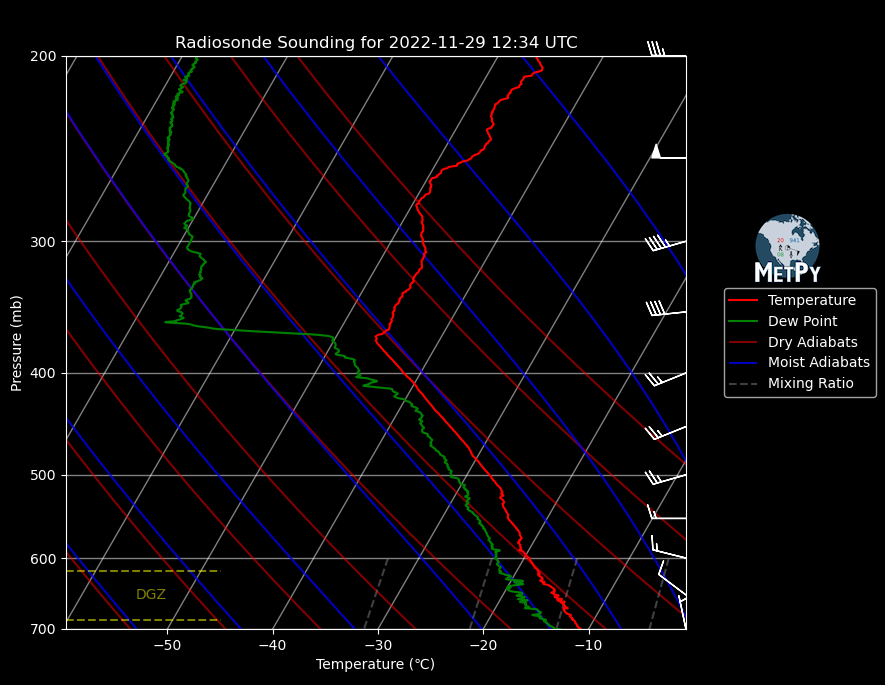

In [41]:
# load the first radiosonde file from sail_high_wind_events
for file in os.listdir(os.path.join(sail_event_data_folder,"radiosonde")):
    sail_radiosonde_ds = xr.open_dataset(f'../../01_data/raw_data/sail_high_wind_events/radiosonde/{file}')
    # add the dewpoint temperature to the dataset
    sail_radiosonde_ds['tdew'] = calc.dewpoint_from_relative_humidity(sail_radiosonde_ds['tdry'],sail_radiosonde_ds['rh'])
    simple_sounding(sail_radiosonde_ds)
    # remove if we want all plots
    break

In [42]:
# create an empty dataframe with pressure as the index with values every 20 hPa from 720 to 200
p = np.arange(200, 710, 10)
sonde_tdry_df = pd.DataFrame(index=p)
sonde_tdew_df = pd.DataFrame(index=p)
sonde_u_df = pd.DataFrame(index=p)
sonde_v_df = pd.DataFrame(index=p)
p = np.arange(190, 710, 10)
for file in os.listdir(os.path.join(sail_event_data_folder,"radiosonde")):
    sail_radiosonde_ds = xr.open_dataset(f'../../01_data/raw_data/sail_high_wind_events/radiosonde/{file}')
    # add the dewpoint temperature to the dataset
    sail_radiosonde_ds['tdew'] = calc.dewpoint_from_relative_humidity(sail_radiosonde_ds['tdry'],sail_radiosonde_ds['rh'])
    # get the first time index and save as a string with format YYYY-MM-DD HH:MM
    time = pd.to_datetime(sail_radiosonde_ds['time'].values[0]).strftime('%Y-%m-%d %H:%M')
    # bin the radiosonde by pressure every 20 hPa
    sonde_tdry_df[time] = sail_radiosonde_ds['tdry'].groupby_bins(sail_radiosonde_ds['pres'], bins=p).mean().values
    sonde_tdew_df[time] = sail_radiosonde_ds['tdew'].groupby_bins(sail_radiosonde_ds['pres'], bins=p).mean().values
    sonde_u_df[time] = sail_radiosonde_ds['u_wind'].groupby_bins(sail_radiosonde_ds['pres'], bins=p).mean().values
    sonde_v_df[time] = sail_radiosonde_ds['v_wind'].groupby_bins(sail_radiosonde_ds['pres'], bins=p).mean().values
# invert the index so that the highest pressure is at the top
sonde_tdry_df = sonde_tdry_df[::-1]
sonde_tdew_df = sonde_tdew_df[::-1]
sonde_u_df = sonde_u_df[::-1]
sonde_v_df = sonde_v_df[::-1]
# get the mean of each dataframe
sonde_tdry_df['mean'] = sonde_tdry_df.mean(axis=1)
sonde_tdew_df['mean'] = sonde_tdew_df.mean(axis=1)
sonde_u_df['mean'] = sonde_u_df.mean(axis=1)
sonde_v_df['mean'] = sonde_v_df.mean(axis=1)
# get the standard deviation of each dataframe
sonde_tdry_df['std'] = sonde_tdry_df.std(axis=1)
sonde_tdew_df['std'] = sonde_tdew_df.std(axis=1)
sonde_u_df['std'] = sonde_u_df.std(axis=1)
sonde_v_df['std'] = sonde_v_df.std(axis=1)    

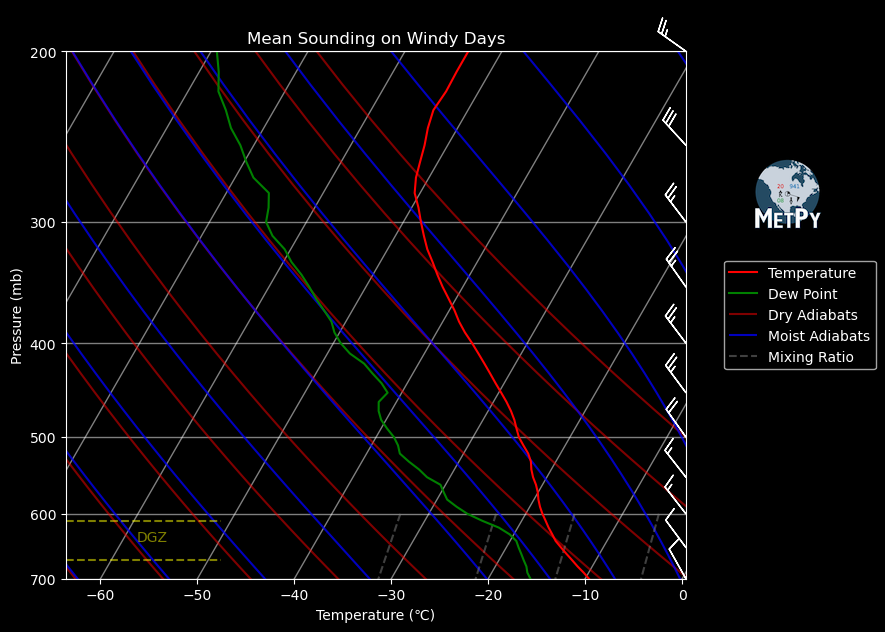

In [45]:
# create a radiosonde mean df with all the mean columns
sonde_mean_df = pd.DataFrame(index=sonde_tdry_df.index)
sonde_mean_df['tdry'] = sonde_tdry_df['mean']
sonde_mean_df['tdew'] = sonde_tdew_df['mean']
sonde_mean_df['u_wind'] = sonde_u_df['mean']
sonde_mean_df['v_wind'] = sonde_v_df['mean']
# reset the index and name the column as 'pres'
sonde_mean_df = sonde_mean_df.reset_index().rename(columns={'index':'pres'})
# create a radiosonde std df with all the std columns
sonde_std_df = pd.DataFrame(index=sonde_tdry_df.index)
sonde_std_df['tdry'] = sonde_tdry_df['std']
sonde_std_df['tdew'] = sonde_tdew_df['std']
sonde_std_df['u_wind'] = sonde_u_df['std']
sonde_std_df['v_wind'] = sonde_v_df['std']
# reset the index and name the column as 'pres'
sonde_std_df = sonde_std_df.reset_index().rename(columns={'index':'pres'})

# plot the mean sounding
mean_sounding(sonde_mean_df, 'Mean Sounding on Windy Days')

Let's look at when precipitation was falling by loading up the laser disdrometer data

In [293]:
# create a list of all the laser_disdrometer_gothic files
sail_ld_files = glob.glob(f'{sail_event_data_folder}laser_disdrometer_gothic*.nc')
gothic_ld_list = []
for file in sail_ld_files:
    # load up the laser disdrometer file
    sail_ld_ds = xr.open_dataset(file)
    # calculate hourly sum of precipitation rate
    sail_ld_ds = sail_ld_ds['precip_rate'].resample(time='1H').sum()/60
    sail_ld_ds.name ='precip_rate'
    sail_ld_df = sail_ld_ds.to_dataframe()
    # separate date and time, make time the index
    sail_ld_df['date'] = sail_ld_df.index.date
    sail_ld_df['time'] = sail_ld_df.index.time
    sail_ld_df = sail_ld_df.set_index('time', drop=True)
    # save one unique date value and drop that column
    date = sail_ld_df['date'].unique()[0]
    sail_ld_df = sail_ld_df.drop(columns=['date'])
    # rename the precip_rate column the date
    sail_ld_df = sail_ld_df.rename(columns={'precip_rate':date})
    # add to the list
    gothic_ld_list.append(sail_ld_df)
gothic_ld_df = pd.concat(gothic_ld_list, axis=1).reset_index().rename(columns={'index':'time'})
gothic_ld_df

time  2022-11-29  2022-12-13  2022-12-14  2022-12-22  2023-01-04  \
0   00:00:00    0.502250    1.595633    0.449333    1.747117    0.841467   
1   01:00:00    1.178033    1.082383    0.203267    1.395767    0.239383   
2   02:00:00    2.333100    0.703450    0.043867    2.039683    0.000000   
3   03:00:00    2.047917    0.390467    0.000000    1.547050    0.010883   
4   04:00:00    3.008200    0.000000    0.019867    2.224100    0.005933   
5   05:00:00    3.237850    0.000000    0.050433    4.393517    0.000000   
6   06:00:00    2.943050    0.000000    0.126750    3.509434    0.046767   
7   07:00:00    2.372150    0.000000    0.105783    5.377100    0.086567   
8   08:00:00    4.190067    0.000000    0.218667    2.131867    0.000000   
9   09:00:00    2.357433    0.000000    0.000000    5.707383    0.000000   
10  10:00:00    7.001317    0.119967    0.000000    1.165417    0.010133   
11  11:00:00    8.854616    0.090450    0.000000    5.109583    0.000000   
12  12:00:00    2.831234    0.196067    0.000000    1.370417    0.000000   
13  13:00:00    1.528617    0.000000    0.000000    3.281550    0.000000   
14  14:00:00    2.742234    0.000000    0.000000    0.187333    0.000000   
15  15:00:00    0.301600    0.000000    0.000000    0.000000    0.000000   
16  16:00:00    0.877667    0.000000    0.000000    0.000000    0.006933   
17  17:00:00    1.185000    0.000000    0.000000    0.000000    0.004483   
18  18:00:00    8.261967    0.000000    0.000000    0.000000    0.000000   
19  19:00:00    7.245749    0.045183    0.003067    0.000000    0.015733   
20  20:00:00    1.812933    0.020433    0.029067    0.000000    0.000000   
21  21:00:00    0.000000    0.208283    0.005383    0.000000    0.000000   
22  22:00:00    0.073983    0.160600    0.000000    0.000000    0.000000   
23  23:00:00    0.202667    0.419950    0.000000    0.000000    0.000000   

    2023-01-25  2023-02-09  2023-03-16  2023-04-15  2023-04-28  
0     0.000000    0.422367    0.499450    0.000000    0.000000  
1     0.000000    1.263033    0.683217    1.163267    0.704700  
2     0.000000    4.180834    0.641383    1.876233    0.742600  
3     0.000000    8.637667    0.525733    0.063267    1.021900  
4     0.000000    0.749700    0.375733    0.313483    0.000000  
5     0.000000    0.630700    1.300467    1.536183    0.109917  
6     0.000000    0.037667    2.503183    5.659983    0.349483  
7     0.018917    0.000000    3.079317    1.627100    0.066167  
8     0.015433    0.000000    0.346067    1.398750    0.508600  
9     0.056167    0.000000    0.000000    0.513200    0.316883  
10    0.233900    0.014517    0.000000    0.446583    0.000000  
11    0.021867    0.000000    0.000000    0.000000    0.000000  
12    0.060233    0.000000    0.006433    0.000000    0.000000  
13    0.146250    0.000000    0.000000    0.170450    0.000000  
14    0.142150    0.000000    0.000000    0.340767    0.000000  
15    0.000000    0.000000    0.000000    0.000000    0.000000  
16    0.000000    0.000000    0.000000    0.009933    0.000000  
17    0.000000    0.000000    0.000000    0.017817    0.000000  
18    0.002700    0.000000    0.004583    0.018733    0.000517  
19    0.008183    0.000000    0.004067    0.008517    0.000000  
20    0.064933    0.000000    0.000483    0.000000    0.000000  
21    0.070167    0.000000    0.000000    0.000000    0.000000  
22    0.127483    0.000000    0.000000    0.000000    0.000000  
23    0.011100    0.000000    0.000000    0.000000    0.000000

In [296]:

# iterate through the dates and plot the wind speed at 10m on uw tower over the day. Color by the day of water year
fig = go.Figure()
for col in gothic_ld_df.columns[1:]:
    # get the day of water year
    day_of_water_year = get_day_of_water_year(col)
    # get the data for the date
    df = gothic_ld_df[["time",col]]
    # plot the data
    fig.add_trace(go.Scatter(
        x=df['time'], 
        y=df[col],
        name=f"{col}",
        marker_color=color_dict[day_of_water_year],
        connectgaps=False
    ))
# update to show all hover data and not just the closest point
fig.update_layout(hovermode="x unified",
                  yaxis_title='Precipitation Rate (mm/hr)',
                    xaxis_title='Time of Day (UTC)',
                    title='Precipitation rate during highest 5th percentile windy days<br>from the Gothic Laser Disdrometer',
)
# update the yaxis to be between 0 and 10
fig.update_yaxes(range=[0, 10])
fig

## 3. How much sublimation over the season came from these events?
We will address this question by calculating hourly sublimation totals from SOS and SAIL over the winter period (dates may need to be adjusted to what Eli calculated with). Then for each of the days we calculated from above, we'll get the total sublimation from those specific days. 
1) First, make a timeseries plot of cumulative sublimation over the year. Add horizontal boxes that mark the days of each wind event
2) Filter the hourly sublimation totals to just the days we want to include and sum the total. 
3) How well the days with the most sublimation correspond with these windy days.

From ELI: 
Some of the sonics look fine. Some sonics mess up the estimates. Filtering is important.

### We'll begin with SOS totals

In [46]:
def clean_covariance(ds, tower, height):
    # print the mean before cleaning for the w_h2o__{height}m_{tower} variable
    print(f"mean before cleaning for w_h2o__{height}m_{tower}: {ds[f'w_h2o__{height}m_{tower}'].mean().values}")
    cleaned = turbulence.clean_eddy_covariance(
                                                ds[f'w_h2o__{height}m_{tower}'].values,
                                                ds[f'counts_{height}m_{tower}'].values,
                                                lower_threshold=np.nanmean(ds[f'w_h2o__{height}m_{tower}'].values)-(np.nanstd(ds[f'w_h2o__{height}m_{tower}'].values) * 5),
                                                upper_threshold=np.nanmean(ds[f'w_h2o__{height}m_{tower}'].values)+(np.nanstd(ds[f'w_h2o__{height}m_{tower}'].values) * 5),
                                            )
    # print the new cleaned mean
    print(f"mean after cleaning for w_h2o__{height}m_{tower}: {np.nanmean(cleaned)}")
    # add the cleaned data back into the dataset
    return cleaned

In [47]:
sos_5min_h2o_flux_ds = sos_5min_ds[[variable for variable in hf.TURBULENCE_VARIABLES if 'w_h2o' in variable]+[variable for variable in hf.COUNT_VARIABLES]]
# get all variables that have _c in them
tower_c = [variable for variable in sos_5min_h2o_flux_ds if '_c' in variable]
# get all variables that have _d in them
tower_d = [variable for variable in sos_5min_h2o_flux_ds if '_d' in variable]
# get all variables that have _ue in them
tower_ue = [variable for variable in sos_5min_h2o_flux_ds if '_ue' in variable]
# get all variables that have _uw in them
tower_uw = [variable for variable in sos_5min_h2o_flux_ds if '_uw' in variable]

for tower in ['c', 'd', 'ue', 'uw']:
    for height in [1, 2, 3, 5, 10, 15, 20]:
        if (height in [2, 5, 10, 15, 20]):
            if (tower == 'c'):
                sos_5min_h2o_flux_ds[f'w_h2o__{height}m_{tower}'].values=clean_covariance(sos_5min_h2o_flux_ds, tower, height)
            elif height == 10:
                sos_5min_h2o_flux_ds[f'w_h2o__{height}m_{tower}'].values=clean_covariance(sos_5min_h2o_flux_ds, tower, height)
        else:
            if (height in [1, 3]) and (tower == 'c'):
                continue
            else:
                sos_5min_h2o_flux_ds[f'w_h2o__{height}m_{tower}'].values=clean_covariance(sos_5min_h2o_flux_ds, tower, height)


mean before cleaning for w_h2o__2m_c: 0.00235001090914011
mean after cleaning for w_h2o__2m_c: 0.0022837081539960227
mean before cleaning for w_h2o__5m_c: 0.002858509076759219
mean after cleaning for w_h2o__5m_c: 0.002657336590708935
mean before cleaning for w_h2o__10m_c: 0.05342699959874153
mean after cleaning for w_h2o__10m_c: 0.0030745565023814992
mean before cleaning for w_h2o__15m_c: 0.0024637978058308363
mean after cleaning for w_h2o__15m_c: 0.0021601575454625464
mean before cleaning for w_h2o__20m_c: 0.0029344167560338974
mean after cleaning for w_h2o__20m_c: 0.0026115149580234185
mean before cleaning for w_h2o__1m_d: 0.0017336503369733691
mean after cleaning for w_h2o__1m_d: 0.0016298994145742846
mean before cleaning for w_h2o__3m_d: 0.002313517965376377
mean after cleaning for w_h2o__3m_d: 0.0026659638186089796
mean before cleaning for w_h2o__10m_d: 0.0031305295415222645
mean after cleaning for w_h2o__10m_d: 0.0027966795466867027
mean before cleaning for w_h2o__1m_ue: 0.002092

In [48]:
sos_5min_h2o_flux_cleaned_ds = sos_5min_h2o_flux_ds[[variable for variable in hf.TURBULENCE_VARIABLES if 'w_h2o' in variable]]

# density of water 
rho_w = 1000 # kg/m^3
# grams to kg conversion
g2kg = 1/1000 # kg/g

# calculate the sublimation rate
sos_5min_h2o_flux_cleaned_ds = sos_5min_h2o_flux_cleaned_ds * 1/rho_w * 1000 * g2kg # convert from g/m^2/s to mm/s

# multiply the value column by the number of seconds in an hour to get the hourly total in mm/hr
sos_daily_h2o_flux_cleaned_ds = sos_5min_h2o_flux_cleaned_ds.resample(time='1D').mean()*3600*24

# save this dataset to the ../../01_data/processed_data folder
sos_daily_h2o_flux_cleaned_ds.to_netcdf('../../01_data/processed_data/sos_daily_h2o_flux_cleaned.nc')

In [454]:
cumulative_sos_sublimation = sos_daily_h2o_flux_cleaned_ds.cumsum(dim='time')
# reset time to be the date 
cumulative_sos_sublimation['time'] = sos_daily_h2o_flux_cleaned_ds['time']
# sort by time
cumulative_sos_sublimation = cumulative_sos_sublimation.sortby('time')
tidy_sublimation = tidy.get_tidy_dataset(cumulative_sos_sublimation, variable_names=[variable for variable in hf.TURBULENCE_VARIABLES if 'w_h2o' in variable])

fig = go.Figure()
color_values = sorted(list(tidy_sublimation.height.dropna().unique()))
n_colors = len(color_values)                      
color_scale = px.colors.sample_colorscale("viridis", [n/(n_colors -1) for n in range(n_colors)])
color_dict = dict(zip(color_values,color_scale))
# plot the sublimation rate
for tower in tidy_sublimation.tower.unique():
    for height in tidy_sublimation.height.unique():
        if len(tidy_sublimation.query(f"tower=='{tower}' and height=={height}")) == 0:
            continue
        else:
            fig.add_trace(go.Scatter(
                x=tidy_sublimation.query(f"tower=='{tower}' and height=={height}")['time'], 
                y=tidy_sublimation.query(f"tower=='{tower}' and height=={height}")['value'],
                name=f"{height} m",
                marker_color=color_dict[height],
                # add tower and height to hover data
                hovertemplate=
                "<b>%{x}</b><br>" +
                "Cumulative Sublimatioon: %{y:.2f} mm<br>" +
                "Tower: " + tower + "<br>" +
                "Height: " + str(height) + " m"+
                "<extra></extra>",
            ),
            )
# update the layout
fig.update_layout(
    title="Cumulative Sublimation at Kettle Ponds Between 2022-11-29 and 2023-05-09",
    xaxis=dict(
        title="Date"
    ),
    yaxis=dict(
        title="Cumulative Sublimation"
    ),
    legend_title="Measurement height\nabove ground (m)",
    # hovermode="x unified",
    width= 800,
    height=400,
)
# update the legend to only show one entry for each height
# https://stackoverflow.com/questions/26939121/how-to-avoid-duplicate-legend-labels-in-plotly-or-pass-custom-legend-labels
names = set()
fig.for_each_trace(
    lambda trace:
        trace.update(showlegend=False)
        if (trace.name in names) else names.add(trace.name))

In [532]:
# get the daily sublimation on the windy days
sos_windy_sublimation = sos_daily_h2o_flux_cleaned_ds.sel(time=windy_days)
# seasonal sublimation total in mm
seasonal_sublimation = cumulative_sos_sublimation.isel(time=-1)
# calculate the percent of seasonal sublimation from windy days
percent_seasonal_sublimation = sos_windy_sublimation.sum(dim='time') / seasonal_sublimation * 100
print(f"Median Seasonal sublimation: {seasonal_sublimation.to_pandas().median()} mm")
print(f"Median Seasonal sublimation on windy days: {sos_windy_sublimation.sum(dim='time').to_pandas().median()} mm")
print(f"Percent of seasonal sublimation on windy days: {percent_seasonal_sublimation.to_pandas().median()} %")
print(f"Percent of days in the 95th percentile of wind: {100*len(windy_days) / len(sos_daily_h2o_flux_cleaned_ds.time)}%")

Median Seasonal sublimation: 36.00474130128656 mm
Median Seasonal sublimation on windy days: 6.268015924555455 mm
Percent of seasonal sublimation on windy days: 17.838619833416146 %
Percent of days in the 95th percentile of wind: 6.25%


In [524]:
# now calculate which days are in the highest 5th percentile of sublimation
# get the 95th percentile of sublimation
sos_sublimation_95th = sos_daily_h2o_flux_cleaned_ds.quantile(0.95, dim='time', method='median_unbiased')
# get the days that are in the 95th percentile
sos_sublimation_95th_days = sos_daily_h2o_flux_cleaned_ds.where(sos_daily_h2o_flux_cleaned_ds > sos_sublimation_95th).dropna(dim='time', how='all').time.values

In [531]:
# get the daily sublimation on the windy days with lots of sublimation
sos_windy_sublimation = sos_daily_h2o_flux_cleaned_ds.sel(time=np.intersect1d(sos_sublimation_95th_days, pd.to_datetime(windy_days)))
# seasonal sublimation total in mm
seasonal_sublimation = cumulative_sos_sublimation.isel(time=-1)
# calculate the percent of seasonal sublimation from windy days
percent_seasonal_sublimation = sos_windy_sublimation.sum(dim='time') / seasonal_sublimation * 100
print(f"Median Seasonal sublimation: {seasonal_sublimation.to_pandas().median()} mm")
print(f"Median Seasonal sublimation on windy days: {sos_windy_sublimation.sum(dim='time').to_pandas().median()} mm")
print(f"Percent of seasonal sublimation on windy days: {percent_seasonal_sublimation.to_pandas().median()} %")
# print the fraction of the total days
print(f"Percent of days in the 95th percentile of sublimation that are also in the 95th percentile of wind: {100*len(np.intersect1d(sos_sublimation_95th_days, pd.to_datetime(windy_days))) / len(sos_daily_h2o_flux_cleaned_ds.time)}%")


Median Seasonal sublimation: 36.00474130128656 mm
Median Seasonal sublimation on windy days: 4.086859342558393 mm
Percent of seasonal sublimation on windy days: 11.742163269469174 %
Percent of days in the 95th percentile of sublimation that are also in the 95th percentile of wind: 2.5%


In [526]:
print("Days in both the 95th percentile of wind and sublimation:")
print(np.intersect1d(sos_sublimation_95th_days, pd.to_datetime(windy_days)))

Days in both the 95th percentile of wind and sublimation:
['2022-12-22T00:00:00.000000000' '2023-03-16T00:00:00.000000000'
 '2023-04-15T00:00:00.000000000' '2023-04-28T00:00:00.000000000']


### Let's Compare with SAIL 
In another notebook, we are going to use a variety of different SAIL data to repeat much of this analysis over the entire SAIL campaign.